In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random
import collections
try:
    from apex import amp, optimizers
    from apex.parallel import DistributedDataParallel as DDP
    from apex.fp16_utils import *
except ImportError:
    raise ImportError("Apex not installed")

In [150]:
# Number of gpus
n_gpu = 2
# Mixed-precision Operation Level
opt_level = 'O1'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


In [179]:
class gaussNoise():
    """Adds gaussian noise to a tensor.

        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     gaussNoise(0.1, 0.05)),
        >>> ])

    """
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)

    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean}, stddev={self.stddev})"
        return repr
#transforms.Compose([gaussNoise(0.1,0.05)])

def AddGaussNoise(x):
    #prob_noise = random.random()
    #if prob_noise >= 0.75:
        #gauss_batches += 1
        ## add random noise to the input images
        x = x + 0.05 * torch.randn(*x.shape)
        # Clip the images to be between 0 and 1
        x = np.clip(x, 0., 1.)
        return x

In [176]:

class AddGaussianNoise(object):
    """Add gaussian noise to a numpy.ndarray (H x W x C)
    """

    def __init__(self, mean, sigma, random_state=np.random):
        self.sigma = sigma
        self.mean = mean
        self.random_state = random_state

    def __call__(self, image):
        if isinstance(self.sigma, collections.Sequence):
            sigma = random_num_generator(
                self.sigma, random_state=self.random_state)
        else:
            sigma = self.sigma
        if isinstance(self.mean, collections.Sequence, random_state=self.random_state):
            mean = random_num_generator(self.mean)
        else:
            mean = self.mean
        row, col, ch = image.shape
        gauss = self.random_state.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row, col, ch)
        image += gauss
        return image

In [212]:
transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                      #transforms.RandomVerticalFlip(),
                                      transforms.RandomAffine(degrees=10,translate=(.05,.05)),
                                      #transforms.RandomRotation(10),
                                      transforms.CenterCrop((26,26)),
                                      transforms.Pad(padding=(3,3,3,3), padding_mode='symmetric'),
                                      transforms.ToTensor(),
                                      #transforms.RandomApply([transforms.Lambda(AddGaussNoise)],p=0.25),
                                      #AddGaussianNoise(0.05,0.05),
                                      #transforms.RandomApply([AddGaussianNoise(0.05,0.05)], p=0.5),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#####################
## Import Datasets ##
#####################
#
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=4,
                         shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=4,
                         shuffle=True, num_workers=2)

# Define Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


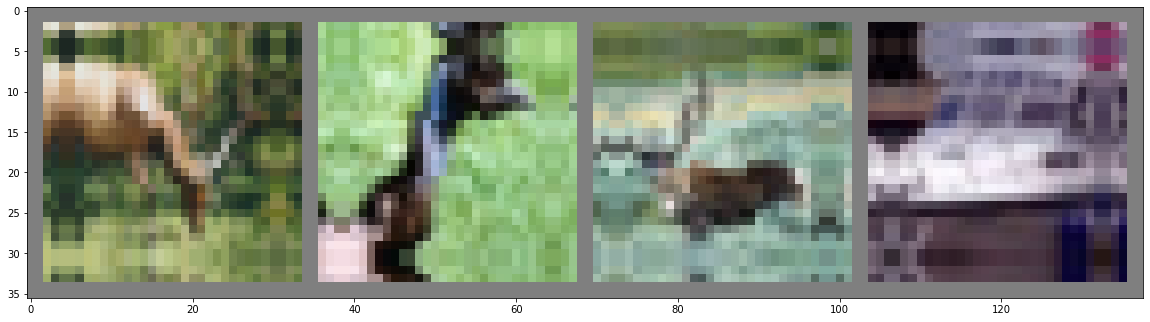

 deer  bird  deer  ship


In [208]:
# Display some training images
def imshow(img):
    img = img / 2 + 0.5     #unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# Get some training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [209]:
#############################
## Define CNN Architecture ##
#############################
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
print('NETWORK MODEL:'); print(model); print()

NETWORK MODEL:
DataParallel(
  (module): LeNet(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)



In [219]:
def model_init(load_if_avail=True, Train=False, checkpoint=-1):
    learning_rate = 0.003
    sched_gamma = 0.7
    sched_step = 5
    
    # Initialize model
    model = LeNet()
    # Send model to GPU
    model = model.to(device)
    
    if Train:
        # Initialize Loss Function    
        criterion = nn.CrossEntropyLoss()
        # Initialize SGD Optimizer
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        # Initialize Learning Rate Scheduler
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=sched_step, gamma=sched_gamma, last_epoch=-1)

        # Amp Initialization
        model, optimizer = amp.initialize(model, optimizer, opt_level=opt_level)

    # Split model between GPUs
    if n_gpu > 1:
        
        model = nn.DataParallel(model, list(range(n_gpu)))

    ##############################
    ## LOAD PREVIOUS CHECKPOINT ##
    ##############################
    # Define directory to save and load checkpoints
    CHECKPOINT_DIR = './checkpoints/LeNet_augm/'

    if load_if_avail:
        # Read in available checkpoints and sort 
        checkpoints = sorted([f for f in os.listdir(CHECKPOINT_DIR) if os.path.isfile(CHECKPOINT_DIR + f)])
        print(); print('CHECKPOINTS AVAILABLE:'); print(checkpoints)
    else:
        checkpoints = []

    # If no checkpoints available
    if len(checkpoints) == 0:
        print('Last Checkpoint: [None]')
        # Start from first epoch
        last_epoch = 0

    # Else if checkpoints available
    else:
        # Load latest checkpoint
        if checkpoint == -1:
            load_checkpoint = checkpoints[-1]
        # Load specified checkpoint
        else:
            load_checkpoint = 'cifar_net_' + checkpoint + '.pt'
        print('Loading Checkpoint:', load_checkpoint)
        
        # Use checkpoint number as last epoch
        last_epoch = int(load_checkpoint[10:-3])
        # Load latest checkpoint
        latest_checkpoint = torch.load(CHECKPOINT_DIR + load_checkpoint)

        # Load model state to resume training
        model.load_state_dict(latest_checkpoint['net'])
        
        if Train:
            model.train()
            # Load Optimizer, Scheduler, and Amp State
            optimizer.load_state_dict(latest_checkpoint['optimizer'])
            scheduler.load_state_dict(latest_checkpoint['scheduler'])
            amp.load_state_dict(latest_checkpoint['amp'])
            # Reassign Scheduler gamma if desired.
            scheduler.gamma = sched_gamma
            scheduler.step_size = sched_step
            #optimizer.param_groups[0]['lr'] = learning_rate
        else:
            model.eval()
    
    print('Last Epoch:', last_epoch); print()
    print('MODEL STATE_DICT:')
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    print()
    if Train:
        print('OPTIMIZER STATE_DICT:')
        for var_name in optimizer.state_dict():
            if var_name != 'state':
                print(var_name, "\t", optimizer.state_dict()[var_name])
        print(); print('SCHEDULER STATE_DICT:')
        for var_name in scheduler.state_dict():
            print(var_name, "\t", scheduler.state_dict()[var_name])
        print('Learning Rate:', scheduler.get_lr()); print()
        
        return model, criterion, optimizer, scheduler, last_epoch
    else:
        return model

In [217]:
model, criterion, optimizer, scheduler, last_epoch = model_init(load_if_avail=True, Train=True)
#######################
## Train the Network ##
#######################

# Define Number of Epochs to train
n_epochs = 6
# Define noise factor 
noise_factor = 0.1

for epoch in range(last_epoch, last_epoch+n_epochs):
    print('EPOCH:', epoch+1, '\t LR:', scheduler.get_lr())
    # Save start times
    ep_start = time.time(); iter_start = ep_start
    
    # Restart running loss and number of gaussian batches
    running_loss = 0.0
    gauss_batches = 0
    # For each batch
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data[0].to(device), data[1].to(device)
        inputs, labels = data[0], data[1]
        """
        # Add noise
        prob_noise = random.random()
        if prob_noise >= 0.75:
            gauss_batches += 1
            ## add random noise to the input images
            inputs = inputs + noise_factor * torch.randn(*inputs.shape)
            # Clip the images to be between 0 and 1
            inputs = np.clip(inputs, 0., 1.)
        """

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        #loss.backward()
        optimizer.step()

        # Print Statistics
        running_loss += loss.item()
        if i % 1000 == 999:
            iter_time = time.time() - iter_start
            print('[%d, %5d] loss: %.3f, Noise batches %d / 1000, TIME: %.3f seconds' %
                  (epoch + 1, i + 1, running_loss / 1000, gauss_batches, iter_time))
            running_loss = 0.0
            gauss_batches = 0
    
    # Step Learning Rate Scheduler
    scheduler.step()
    
    ep_time = time.time() - ep_start
    print('END EPOCH:', epoch+1, 'TIME:', ep_time, 'seconds'); print()
    
    # Save checkpoint every 5 epochs
    if (epoch+1) % 5 == 0:
        PATH = CHECKPOINT_DIR+'cifar_net_' + str(epoch+1) + '.pt'
        current_state = {'net': model.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(),
                         'amp': amp.state_dict()}
        torch.save(current_state, PATH)
        print('Checkpoint for Epoch', epoch+1, 'saved in', PATH); print()
    
print('Finished Training')

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic

CHECKPOINTS AVAILABLE:
['cifar_net_2.pt']
Loading Checkpoint: cifar_net_2.pt
Last Epoch: 2

MODEL STATE_DICT:
module.conv1.weight 	 torch.Size([6, 3, 5, 5])
module.conv1.bias 	 torch.Size([6])
module.conv2.weight 	 torch.Size([16, 6, 5, 5])
module.conv2.bias 	 torch.Size([16])
module.fc1.weight 	 torch.Size([12


CHECKPOINTS AVAILABLE:
['cifar_net_2.pt']
Loading Checkpoint: cifar_net_2.pt
Last Epoch: 2

MODEL STATE_DICT:
module.conv1.weight 	 torch.Size([6, 3, 5, 5])
module.conv1.bias 	 torch.Size([6])
module.conv2.weight 	 torch.Size([16, 6, 5, 5])
module.conv2.bias 	 torch.Size([16])
module.fc1.weight 	 torch.Size([120, 400])
module.fc1.bias 	 torch.Size([120])
module.fc2.weight 	 torch.Size([84, 120])
module.fc2.bias 	 torch.Size([84])
module.fc3.weight 	 torch.Size([10, 84])
module.fc3.bias 	 torch.Size([10])



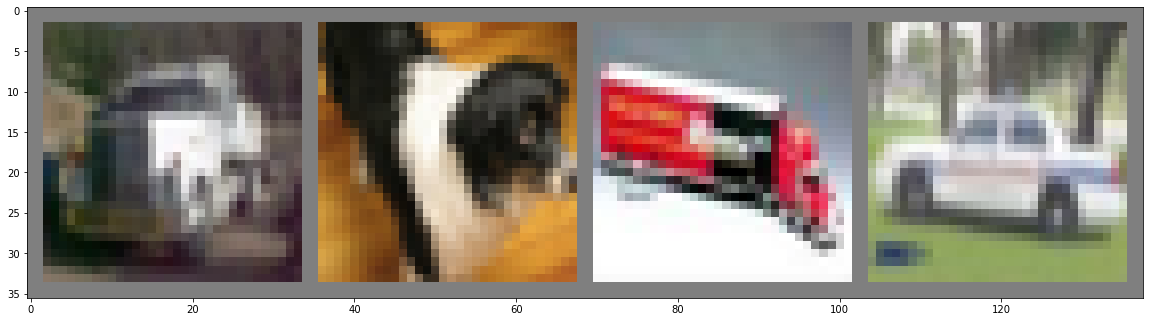

GroundTruth: truck   dog truck   car
Predicted:    dog   dog plane   car


In [220]:
model = model_init(load_if_avail=True, Train=False, checkpoint=-1)

dataiter = iter(testloader)
images, labels = dataiter.next()

# Print Images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


"""
model = LeNet()
model.to(device)
if n_gpu > 1:
    model = nn.DataParallel(model, list(range(n_gpu)))

# Load latest checkpoint
latest_checkpoint = torch.load(PATH)
    
# Load model state
model.load_state_dict(latest_checkpoint['net'])
model.eval()
"""

images, labels = images.to(device), labels.to(device)
outputs = model(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [221]:
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total)); print()
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 49 %

Accuracy of plane : 49 %
Accuracy of   car : 53 %
Accuracy of  bird : 34 %
Accuracy of   cat : 37 %
Accuracy of  deer : 30 %
Accuracy of   dog : 44 %
Accuracy of  frog : 66 %
Accuracy of horse : 56 %
Accuracy of  ship : 62 %
Accuracy of truck : 55 %
